<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/master/CorEx_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mounting the drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

##All Imports go here but first, installations

In [0]:
!pip install corextopic
!pip install joblib

In [0]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import pandas as pd

from corextopic import corextopic as ct
from corextopic import vis_topic as vt 
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

##Reading the data

In [0]:
df = pd.read_csv('/gdrive/My Drive/reviews_samples.csv')
df.head()
df.shape

(993490, 10)

In [0]:
#Converting the DF to list to feed to the CorEx Model
dfToList = df['summary'].tolist()

dfList = list(df['summary'])

dfValues = df['summary'].values
#print(dfList)
print(dfValues)

['Delish' 'Just what my husband wanted' 'Love This Show!' ...
 'Comfy Chaise!' 'Great for the Entire Family' 'Really glad I bought this']


##Building Dictionary,Term-Doc Matrix

In [0]:
# Transform Amazon Reviews data into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', max_features=20000,binary = True)
doc_word = vectorizer.fit_transform(df['summary'].values.astype('U')) #Learn the vocabulary dictionary and return term-document matrix.
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(993490, 20000)

In [0]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

In [0]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(993490, 19098)

##Training the CorEx Topic Model

In [0]:
# Train the CorEx topic model with 10 topics
topic_model = ct.Corex(n_hidden=10, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [0]:
# Print a single topic from CorEx topic model. This model is trained on the Amazon Garden and Lawn Products
topic_model.get_topics(topic=7, n_words=10)

[('hose', 0.029132999383915236),
 ('heavy', 0.01669357131735469),
 ('duty', 0.010935424893359016),
 ('reel', 0.005973615250989113),
 ('weight', 0.005672835147350455),
 ('light', 0.005503785856799797),
 ('umbrella', 0.005076314694303988),
 ('patio', 0.0031858289356087957),
 ('cover', 0.0029471155393640002),
 ('easily', 0.0027251459014974657)]

In [0]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: trimmer,washer,electric,replacement,black,mower,battery,solar,decker,cordless
1: feeder,bird,best,snow,ve,squirrel,garden,product,weed,hummingbird
2: money,waste,trap,worth,away,bugs,mouse,bug,save,mice
3: great,good,love,like,price,quality,plant,birds,did,seeds
4: don,time,water,long,broke,buy,year,months,problem,know
5: grill,weber,bbq,charcoal,outdoor,smoker,brush,cooking,heat,char
6: easy,does,job,use,fast,shipping,install,quick,delivery,gets
7: hose,heavy,duty,reel,weight,light,umbrella,patio,cover,easily
8: pool,pump,parts,missing,cleaner,poorly,intex,description,cheaper,ground
9: just,excellent,needed,exactly,junk,service,looking,right,piece,didn


In [0]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(7448, 0.026388301996361992),
 (18376, 0.018571382184366075),
 (1587, 0.005509258632415831),
 (2946, 0.00481149318882399),
 (11646, 0.004090152030781693),
 (15242, 0.0035619354247982357),
 (2332, 0.003290337050958336),
 (3730, 0.003054574616373883),
 (7897, 0.0028796312760634014),
 (2942, 0.002871438855985352)]

In [0]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[0 7 7 ... 3 1 1]
(19098,)


In [0]:
# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=7, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(424066, 0.0),
 (119096, 0.0),
 (949163, 0.0),
 (340507, 0.0),
 (423669, 0.0),
 (126295, 0.0),
 (502064, 0.0),
 (119301, 0.0),
 (155047, 0.0),
 (805199, 0.0)]

In [0]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(993490, 10)


In [0]:
print(topic_model.labels.shape) # n_docs x k_topics

(993490, 10)


##Total Corelation and Model Selection

In [0]:
#Here trying to implement what the paper proposes. Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through tc and is reported in nats.
topic_model.tc 

0.4514645920166664

In [0]:
topic_model.tcs.shape # k_topics

(10,)

In [0]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

0.4514645920166664
0.4514645920166664


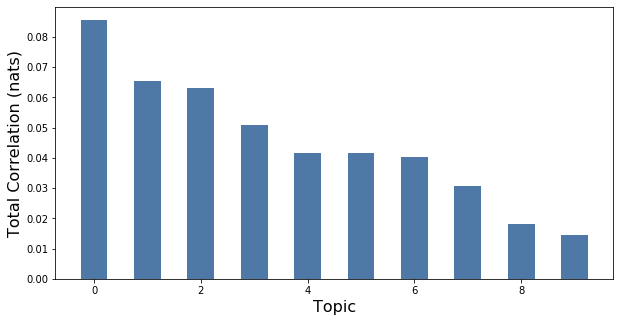

In [0]:
#Selecting number of topics:Choosing from the data visualised
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('Distribution of TCs for each topic', dpi=600)

##Pointwise Document TC

In [0]:
topic_model.log_z.shape # n_docs x k_topics

(993490, 10)

In [0]:
print(np.mean(topic_model.log_z, axis=0)) #The pointwise total correlations in log_z represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics
print(topic_model.tcs)

[0.08558585 0.06529124 0.06312844 0.05079521 0.04153885 0.04149329
 0.04010682 0.03071867 0.01818844 0.01461778]
[0.08558585 0.06529124 0.06312844 0.05079521 0.04153885 0.04149329
 0.04010682 0.03071867 0.01818844 0.01461778]


##Now adding some hierarchy to the Topic Model

In [0]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

In [0]:
vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')


##Introducing Anchoring in the semi-supervised topic model

In [0]:
# Anchor one word to the seventh topic
anchor_words = ['shipping']

In [0]:
# Anchor the word 'shipping' to the seventh topic
anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [0]:
topic_words,_ = zip(*anchored_topic_model.get_topics(topic=6))
print('6: ' + ','.join(topic_words))

6: amazing,leaks,wow,simply,cracked,incredible,invention,gadget,leaky,half


In [0]:
# Anchor 'electric' and 'electronic' to first topic, 'birds' and 'garden' to second topic, so on...
anchor_words = [['electric', 'electronic'], ['birds', 'garden'], ['money', 'worth'], ['price', 'quality']]

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [0]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: electric,trimmer,electronic,mower,decker,blower,cordless,washer,black,chain
1: garden,birds,love,fairy,herb,addition,kneeler,weasel,stool,raised
2: money,worth,waste,save,penny,spent,wasted,extra,spend,cost
3: quality,price,poor,high,reasonable,low,beat,decent,fair,build


In [0]:
# Anchor with single words and groups of words
anchor_words = ['job', ['job', 'use'], ['job', 'delivery'], 'shopping']

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [0]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: job,does,gets,doing,dose,adequately,certainly,adequate,doin,slower
1: use,job,easy,ease,lightweight,occasional,indoor,everyday,residential,pleasure
2: job,delivery,prompt,speedy,timely,ref,www,gp,http,nicely
3: mower,trimmer,blower,lawn,electric,black,cordless,chain,saw,decker


In [0]:
vt.vis_rep(topic_model, column_label=words, prefix='./twenty')

In [0]:
%pwd
%cd /content/
%pwd

/content


'/content'

In [0]:
#Saving the CorEx topics generated in a file
import sys
import csv
with open("corex_topic.txt","w+") as file:
     for n in range(len(anchor_words)):
         topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
         #print('{}: '.format(n) + ','.join(topic_words))
         file.write('{}: '.format(n) + ','.join(topic_words)+'\n')